In [13]:
/**
 * @file rocket-injector-design-cpp.ipynb
 * 
 * This notebook demonstrates a practical application of Multi-Objective Optimizers. The design of the injector surface is
 * modified to study its effect on the thrust chamber environment and performance. The optimizer simultaneously balances these   
 * objectives to returns a set of Pareto optimal solutions.
 *
 * Also known as RE3-4-7, this problem has been taken from "An Easy-to-use Real-world Multi-objective
 * Optimization Problem Suite" paper. For more information, visit: https://github.com/ryojitanabe/reproblems.
 */

In [2]:
#include <mlpack/xeus-cling.hpp>

#include <ensmallen.hpp>

In [3]:
// Header files to create and show the plot.
#define WITHOUT_NUMPY 1
#include "matplotlibcpp.h"
#include "xwidgets/ximage.hpp"

namespace plt = matplotlibcpp;

In [4]:
using namespace ens;

In [5]:
using namespace ens::test;

### 1. Background

This problem aligns with NASA's larger goal of the **Next Generation Launch Technology (NGLT)** Program aimed at durable and high-performance launch systems. In a simplistic setting, a rocket system generally consists of two liquid propellants, an oxidiser ($O_2$) and fuel ($H_2$). These propellants are mixed with the help of an injector machine. The injector machine is connected directly to the combuston chamber where the reaction occur. 


The mixing of $H_2$ and $O_2$ is inherently an [exothermic](https://en.wikipedia.org/wiki/Exothermic_process) phenomenon; it lets out heat. This reaction is the principle behind the take-off of rockets.

$$ 2H_2 + O_2\  -> 2H_2 O + 241.8 kJ$$

Propellants mix

### 2. Framing the problem.


#### I. Design Variables
The design of the injector is directly related to these objectives. By controlling the design variables of the injector, we 

The variables concerning the design of the injector are:

a) Hydrogen Flow Angle ($\alpha$) : The acute angle formed between the fuel and oxidiser.

b) Hydrogen Area ($H.A$):  The area of the tube

c) Oxygen Area ($O.A$):

d) Oxygen Post-Tip-Thickness ($O.P.T.T$): 

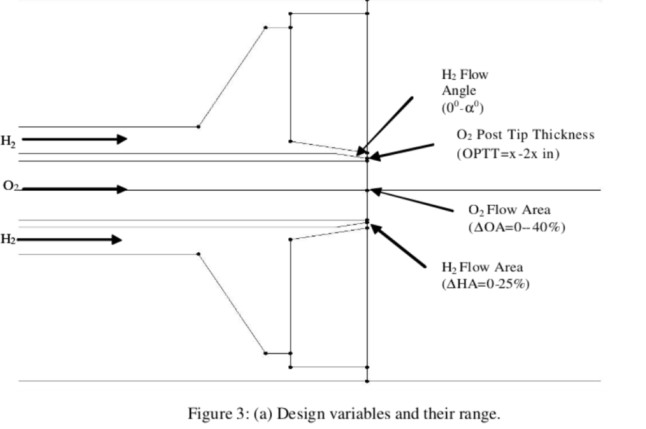

#### II. Objective Functions

a) Maximum Temperature At Injector Face:

b) Distance From Inlet:

c) 

In [6]:
class InjectorDesignProblem
{
  public:
    InjectorDesignProblem()
    { /* Nothing to do here. */ }
    
    //! Get the starting point.
    arma::mat GetInitialPoint()
    {
      return arma::mat(numVariables, 1, arma::fill::zeros);
    }
    
    //! The maximum temperature at the injector face.
    struct InjectorFaceHeatCap
    {
        InjectorFaceHeatCap() {}

        double Evaluate(const arma::mat& coords)
        {
            DesignVariables x(coords);
            return 0.692 + (0.477 * x.Alpha) - (0.687 * x.HA) - (0.080 * x.OA) - (0.0650 * x.OPTT) - (0.167 * x.Alpha * x.Alpha)
                - (0.0129 * x.HA * x.Alpha) + (0.0796 * x.HA * x.HA) - (0.0634 * x.OA * x.Alpha) - (0.0257 * x.OA * x.HA)
                + (0.0877 * x.OA * x.OA) - (0.0521 * x.OPTT * x.Alpha) + (0.00156 * x.OPTT * x.HA) + (0.00198 * x.OPTT * x.OA)
                + (0.0184 * x.OPTT * x.OPTT);
        }    
    };
    
    //! Distance from inlet where 90% combustion is complete.
    struct DistanceFromInlet
    {
        DistanceFromInlet() {}
        
        double Evaluate(const arma::mat& coords)
        {
            DesignVariables x(coords);
            return 0.153 - (0.322 * x.Alpha) + (0.396 * x.HA) + (0.424 * x.OA) + (0.0226 * x.OPTT)
                + (0.175 * x.Alpha * x.Alpha) + (0.0185 * x.HA * x.Alpha) - (0.0701 * x.HA * x.HA) - (0.251 * x.OA * x.Alpha)
                + (0.179 * x.OA * x.HA) + (0.0150 * x.OA * x.OA) + (0.0134 * x.OPTT * x.Alpha) + (0.0296 * x.OPTT * x.HA)
                + (0.0752 * x.OPTT * x.OA) + (0.0192 * x.OPTT * x.OPTT);
        }
    };
    
    //! The maximum temperature at the post tip.
    struct PostTipHeatCap
    {
        PostTipHeatCap() {}
        
        double Evaluate(const arma::mat& coords)
        {
            DesignVariables x(coords);
            return 0.370 - (0.205 * x.Alpha) + (0.0307 * x.HA) + (0.108 * x.OA) + (1.019 * x.OPTT)
                - (0.135 * x.Alpha * x.Alpha) + (0.0141 * x.HA * x.Alpha) + (0.0998 * x.HA * x.HA) + (0.208 * x.OA * x.Alpha)
                - (0.0301 * x.OA * x.HA) - (0.226 * x.OA * x.OA) + (0.353 * x.OPTT * x.Alpha) - (0.0497 * x.OPTT * x.OA)
                - (0.423 * x.OPTT * x.OPTT) + (0.202 * x.HA * x.Alpha * x.Alpha) - (0.281 * x.OA * x.Alpha * x.Alpha)
                - (0.342 * x.HA * x.HA * x.Alpha) - (0.245 * x.HA * x.HA * x.OA) + (0.281 * x.OA * x.OA * x.HA)
                - (0.184 * x.OPTT * x.OPTT * x.Alpha) - (0.281 * x.HA * x.Alpha * x.OA);
        }

    };

    //! Get objective functions.
    std::tuple<InjectorFaceHeatCap, DistanceFromInlet, PostTipHeatCap> GetObjectives()
    {
      return std::make_tuple(InjectorFaceHeatCap{}, DistanceFromInlet{}, PostTipHeatCap{});
    }
                        
  private:
    //! A wrapper for the design variables. Used for better
    //! readibility.
    struct DesignVariables
    {
        DesignVariables(const arma::mat& coords)
        {
            Alpha = coords[0];
            HA = coords[1];
            OA = coords[2];
            OPTT = coords[3];
        }
        
        //! Hydrogen flow angle.
        double Alpha;
        //! Hydrogen area.
        double HA;
        //! Oxygen area.
        double OA;
        //! Oxidiser Post Tip Thickness.
        double OPTT;
    };
    
    size_t numVariables = 4;
    size_t numObjectives = 2;
};

InjectorDesignProblem idp;
auto objectives = idp.GetObjectives();

In [7]:
const double lowerBound = 0;
const double upperBound = 1;

DefaultMOEAD moead(300, // Population size.
                   150,  // Max generations.
                   1.0,  // Crossover probability.
                   0.9, // Probability of sampling from neighbor.
                   20, // Neighborhood size.
                   20, // Perturbation index.
                   0.5, // Differential weight.
                   2, // Max childrens to replace parents.
                   1E-10, // epsilon.
                   lowerBound, // Lower bound.
                   upperBound // Upper bound.
                 );

arma::mat coords = idp.GetInitialPoint();

In [8]:
moead.Optimize(objectives, coords);

In [9]:
const arma::cube& paretoFront = moead.ParetoFront();